In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa
import seaborn as sns
import scipy

In [2]:

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, auc

from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline

from sklearn.decomposition import PCA


### recompute f0 features and add zcr and mfcc

In [3]:
from scipy import stats
def get_stats(x):
    if np.any(x) == False:
        return np.nan,np.nan,np.nan,np.nan,np.nan, np.nan, np.nan
    else:
        return x.mean(),x.std(),x.var(),x.min(), x.max(), stats.skew(x),stats.kurtosis(x) 
        #for variance, np.var uses ddof=0 as default, whereas scipy.stats use ddof=1 

In [4]:
data_dir = '/Users/yingli/Development/AppliedDataScience/voice_clips/'
voice_clip_meta_data = pd.read_csv("voice_clips_meta_data.csv")
voice_features = pd.read_csv("/Users/yingli/Development/AppliedDataScience/voice_features_20230404.csv")


In [5]:
age_names = ['teens', 'twenties','thirties', 'fourties', 
            'fifties', 'sixties', 'seventies', 'eighties']
gender_names = ["male","female"]
voice_features['age'].replace(age_names,[1,2,3,4,5,6,7,8],inplace = True)
voice_features['gender'].replace(gender_names,[0,1], inplace=True)
col_list_mfcc = ['mfcc_00', 'mfcc_01', 'mfcc_02', 'mfcc_03', 'mfcc_04', 'mfcc_05',
       'mfcc_06', 'mfcc_07', 'mfcc_08', 'mfcc_09', 'mfcc_10', 'mfcc_11',
       'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17',
       'mfcc_18', 'mfcc_19', 'mfcc_20', 'mfcc_21', 'mfcc_22', 'mfcc_23',
       'mfcc_24']
col_list_f0 = ['f0_mean', 'f0_std','f0_var','f0_min','f0_max','f0_skew', 'f0_kurtosis']
col_list_zcr = ['zcr_mean','zcr_std','zcr_var','zcr_min','zcr_max','zcr_skew','zcr_kurtosis']

In [6]:
voice_features.dropna(inplace=True)

              precision    recall  f1-score   support

           1     0.7251    0.6767    0.7001       764
           2     0.7208    0.6621    0.6902      1474
           3     0.6239    0.8526    0.7205      1282
           4     0.6968    0.5409    0.6090       599
           5     0.5657    0.4410    0.4956       322
           6     0.7679    0.7072    0.7363       304
           7     0.7714    0.4793    0.5912       169
           8     0.9231    0.7500    0.8276        32

    accuracy                         0.6818      4946
   macro avg     0.7243    0.6387    0.6713      4946
weighted avg     0.6893    0.6818    0.6774      4946



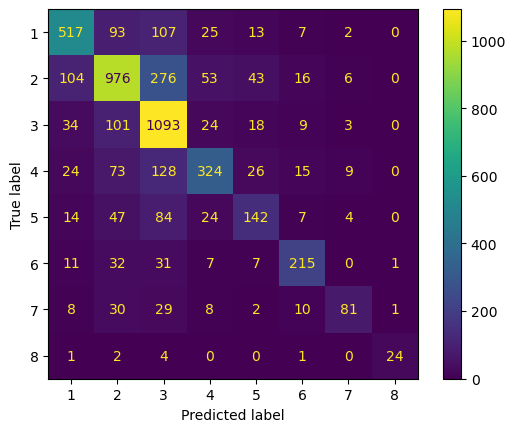

In [36]:
X = voice_features[col_list_f0 + col_list_mfcc+col_list_zcr]
scaler = preprocessing.MinMaxScaler().fit(X)
X = scaler.transform(X)
y = voice_features.age

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=7)

mlp_clf = MLPClassifier(random_state=1, max_iter=1000, hidden_layer_sizes=(500)).fit(X_train, y_train)
y_pred = mlp_clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred, digits = 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

### gender classification accuracy
#### older set of features: f0 mean + var + skew+ kurtosis, zcr mean, 40 mfcc
* f0 alone: 92
* f0+zcr: 93
* f0+ mfcc: 96.7%
* f0+mfcc+zcr: 97.43 (max_iter = 500)
* f0+mfcc+zcr: 97.59 (max_iter = 1000)

#### newer set of features: f0 and zcr mean, std, var, min, max, skew, kurtosis, 25 mfcc
* f0 alone: 93
* f0 + zcr: 94
* f0 + mfcc: 95.7
* f0 + mfcc+zcr: 96.4
* full set, mlp with (500,300) layers: 97.3

* using ridge: 92
* randomforest: 96, adjusting n_estimator and max_depth did not seem to improve much


#### age recognition on new features
* all features: 0.62, sixties highest
* f0 + mfcc: 0.60, eighties is highest
* mfcc: 0.60
* f0 alone: very bad perfromance

* using ridge on older set of features 
* full features: 0.35
* new full features: 0.34


              precision    recall  f1-score   support

           0     0.9260    0.9687    0.9469      3580
           1     0.9067    0.7972    0.8485      1366

    accuracy                         0.9214      4946
   macro avg     0.9164    0.8830    0.8977      4946
weighted avg     0.9207    0.9214    0.9197      4946



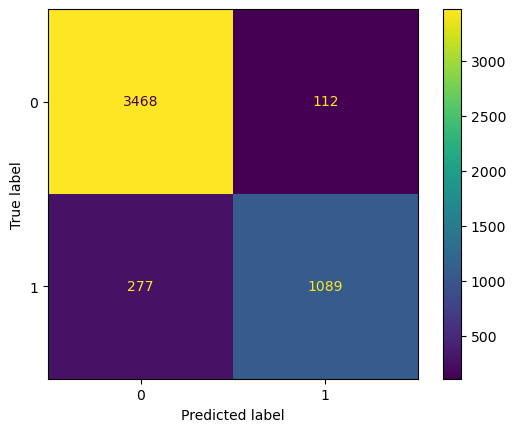

In [22]:
X = voice_features[col_list_f0+col_list_mfcc]
scaler = preprocessing.MinMaxScaler().fit(X)
X = scaler.transform(X)
y = voice_features.gender
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=7)
ridge_clf = RidgeClassifier(tol=1e-2, solver="svd")
ridge_clf = ridge_clf.fit(X_train, y_train)
y_pred = ridge_clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred, digits = 4))
#ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

              precision    recall  f1-score   support

           0     0.9715    0.9715    0.9715      3580
           1     0.9253    0.9253    0.9253      1366

    accuracy                         0.9588      4946
   macro avg     0.9484    0.9484    0.9484      4946
weighted avg     0.9588    0.9588    0.9588      4946



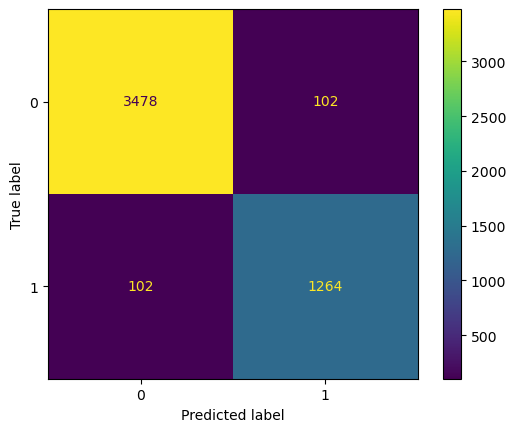

In [29]:
X = voice_features[col_list_f0+col_list_mfcc+col_list_zcr]
scaler = preprocessing.MinMaxScaler().fit(X)
X = scaler.transform(X)
y = voice_features.gender
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=7)
rf_clf = RandomForestClassifier(max_depth=100, n_estimators=1000)
rf_clf = rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred, digits = 4))
#ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [33]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score

def find_elbow(df, colnames, clusters_range):
    df_for_cluster = df.loc[:,colnames]
    stscaler = StandardScaler().fit(df_for_cluster)
    normalized_df = stscaler.transform(df_for_cluster)

    inertias = [] # wcss: Within Cluster Sum of Squares
    for k in clusters_range:
        kmeans = KMeans(init='k-means++',n_clusters=k,n_init=100, max_iter=300, random_state=0).fit(normalized_df)
        inertias.append(kmeans.inertia_)
    plt.figure()
    plt.plot(clusters_range,inertias, marker='o')
    plt.title('Elbow method for deciding on k')
    plt.xlabel('Number of clusters: k')
    plt.ylabel('inertia')
    plt.show()
    return

def run_kmeans(df, colnames, k):
    df_for_cluster = df.loc[:,colnames]
    stscaler = StandardScaler().fit(df_for_cluster)
    normalized_df = stscaler.transform(df_for_cluster)

    kmeans = KMeans(init='k-means++',n_clusters=k,n_init=100, max_iter=300, random_state=0).fit(normalized_df)
    df['cluster'] = kmeans.labels_
    return df

In [34]:
voice_features = run_kmeans(voice_features,col_list_mfcc+col_list_f0+col_list_zcr, 6)
voice_features.cluster.value_counts()

4    3690
2    3412
5    2941
3    2408
1    1600
0     936
Name: cluster, dtype: int64

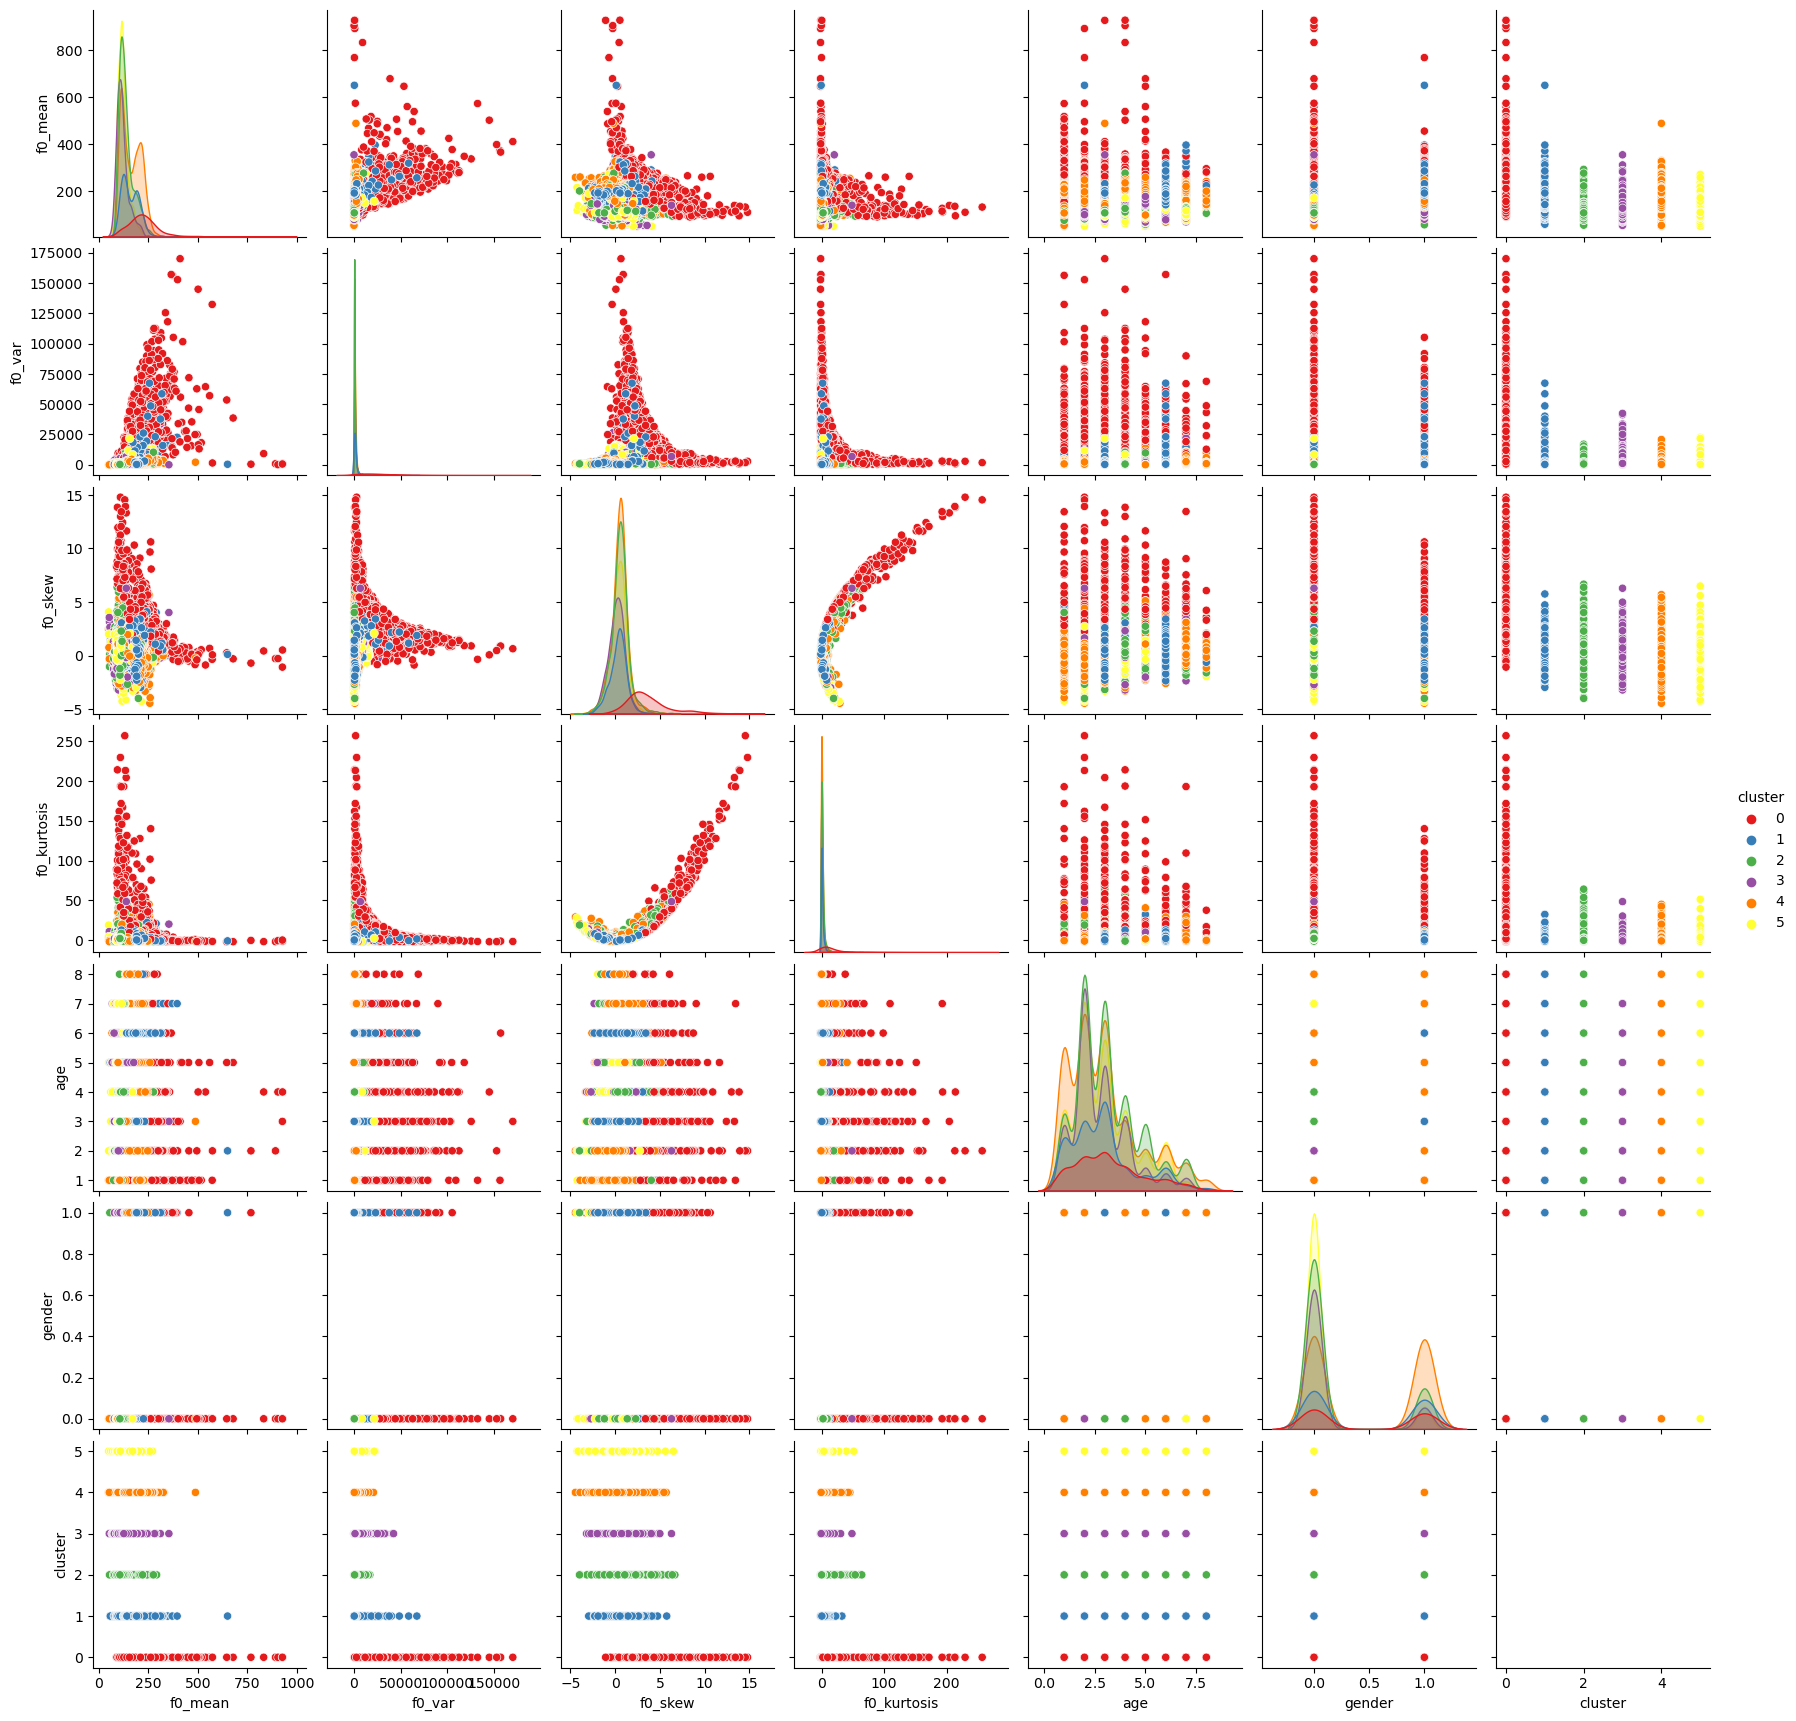

In [35]:
sns.pairplot(voice_features, vars = ["f0_mean","f0_var","f0_skew", "f0_kurtosis", "age","gender","cluster"],hue="cluster",palette="Set1")

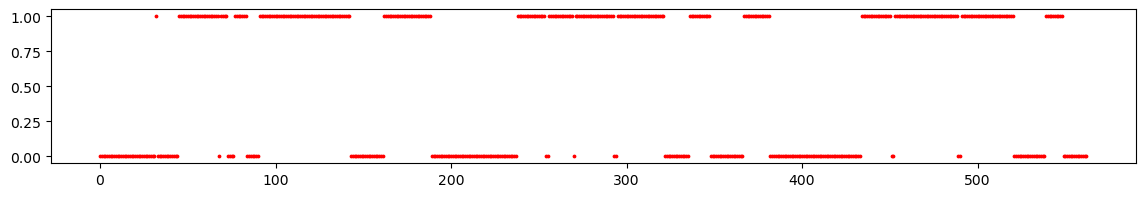

In [56]:
my_voice = "/Users/yingli/Development/AppliedDataScience/John_1_1_YingLi.wav" # Ying's voice
y, y_sr = librosa.load(my_voice, sr=None, mono=True)
y_f0, y_voiced_flag, y_voiced_probs = librosa.pyin(y,sr=y_sr, fmin=50, fmax=1000, fill_na=None)
y_zcr = librosa.feature.zero_crossing_rate(y=y)

plt.figure(figsize=(14, 2))
plt.scatter(range(y_voiced_flag.shape[1]), y_voiced_flag[0,:]*1,s = 3, color = "r")


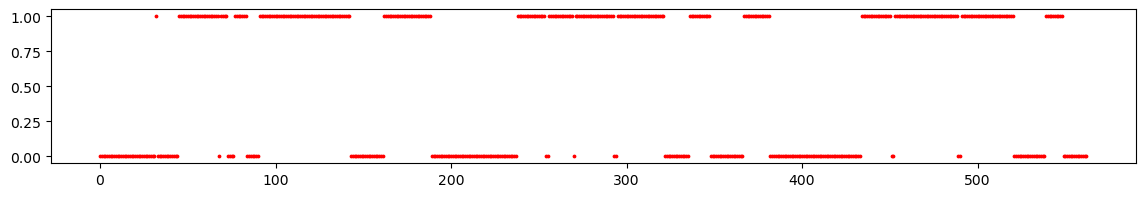

In [57]:
plt.figure(figsize=(14, 2))
plt.scatter(range(y_voiced_flag.shape[1]), y_voiced_flag[1,:]*1,s = 3, color = "r")

In [63]:
tempo, beat_frames = librosa.beat.beat_track(y=x, sr=sr)
print('Estimated tempo: {:.2f} beats per minute'.format(tempo))

Estimated tempo: 93.75 beats per minute


In [64]:
# 4. Convert the frame indices of beat events into timestamps
beat_times = librosa.frames_to_time(beat_frames, sr=sr)
beat_times

array([0.448, 1.088, 1.712])

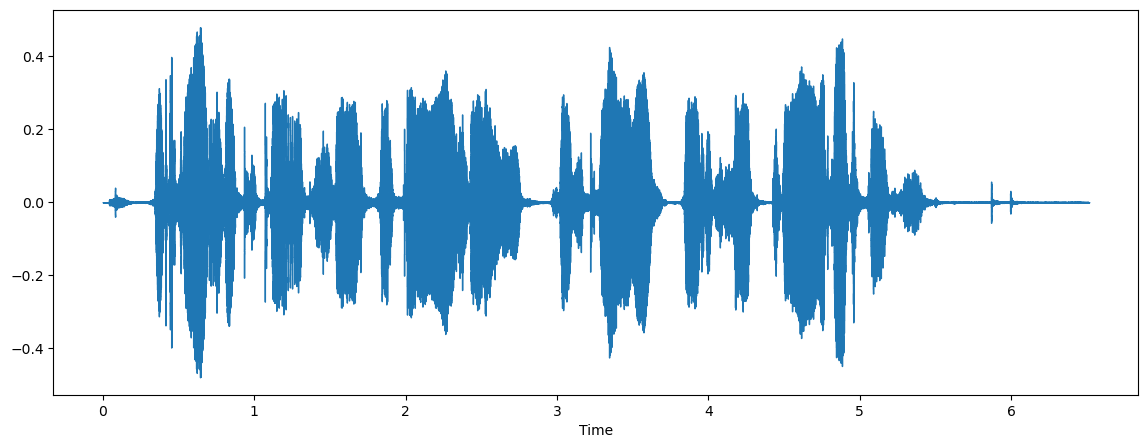

In [65]:
audiofile = "common_voice_en_35117939.mp3" # teen female
x, sr = librosa.load(data_dir+audiofile)
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)